In [1]:
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import uuid
import cv2
import numpy as np
from random import randint
import random
from PIL import Image
import json
import copy

from tqdm.notebook import tqdm
from time import sleep

## Load flowers and bushes only data (i.e. without bees)

In [2]:
flowers_img_dir = "./flower_bushes_data" #SET PATH TO DIR OF FLOWERS AND BUSHES DATA
flowers_jpg_src = glob.glob(os.path.join(flowers_img_dir, "*.jpg"))
no_of_flower_images = len(flowers_jpg_src)
print("No. of images {}".format(no_of_flower_images))

No. of images 988


In [3]:
flower_img_names = []
for jpg_path in flowers_jpg_src:
    flower_img_name = os.path.basename(jpg_path)
    flower_img_names.append(flower_img_name)
print(flower_img_names[0])

30973268262_03c25e3552_b.jpg


## Load bees on flower data

In [4]:
bee_img_dir = "./bee_flowers_data" #SET PATH TO DIR OF BEES ON FLOWERS DATA
bee_jpg_src = glob.glob(os.path.join(bee_img_dir, "*.jpg"))
no_of_images = len(bee_jpg_src)
print("No. of images {}".format(no_of_images))

No. of images 996


In [5]:
with open(os.path.join(bee_img_dir, 'via_export_json.json')) as json_file: #read annotation data
    annotation_data = json.load(json_file)
json_file.close()

In [6]:
list(annotation_data.keys())[0]

'3233433_4cc04081c2_b.jpg226137'

In [7]:
bee_entry_names = [name for name in annotation_data]
#entry_names

In [8]:
annotation_data[bee_entry_names[0]] #example output

{'filename': '3233433_4cc04081c2_b.jpg',
 'size': 226137,
 'regions': [{'shape_attributes': {'name': 'rect',
    'x': 292,
    'y': 159,
    'width': 347,
    'height': 310},
   'region_attributes': {}}],
 'file_attributes': {}}

In [9]:
bee_img_entry_names = {} #mapping between actual filename and entry name .jpg###### of json
for entry_name in bee_entry_names:
    bee_img_entry_names[annotation_data[entry_name]['filename']] = entry_name
bee_img_names = list(bee_img_entry_names.keys())

In [10]:
annotation_data[bee_img_entry_names["26884949464_09f4c90786_b.jpg"]]["regions"][0]['shape_attributes'] #example output

{'name': 'rect', 'x': 276, 'y': 177, 'width': 504, 'height': 294}

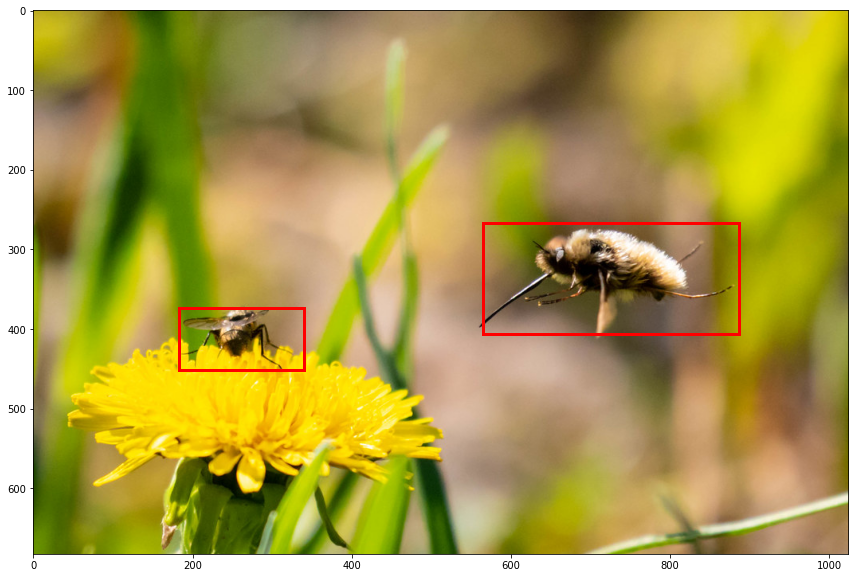

In [11]:
rand_img_name = bee_img_names[randint(0, no_of_images)]
rand_img_name = '41603812094_1458d0ee9c_b.jpg'
test_img = plt.imread(os.path.join(bee_img_dir, rand_img_name))

fig, ax = plt.subplots(figsize = (15, 10))
ax.imshow(test_img)
for region in annotation_data[bee_img_entry_names[rand_img_name]]['regions']:
    shape = region['shape_attributes']
    rect = patches.Rectangle((shape["x"], shape["y"]), shape['width'], shape['height'], linewidth=3, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.show()

# Generate Sub Images

In [12]:
img_stacking_shape = (3,4) #4 subimages on y axis and 6 on x axis
bee_proba = 0.3 #proba that bee is choosen 

In [13]:
def generate_mosaic_img(bee_proba = 0.3, plot=0, verbose=0):
    """
    Generates mosaic image by combining image data of bees on flowers and flowers/bushes alone.
    Saves mosaic image by uuid4 file-format. Returns json/dict entry in order to be stored in json file.
    
    Parameters:
        bee_proba (float): Probability of bee images in mosaic image
        
    Return:
        json_entry (dict): Json entry with filename as key and annotation as value.
    """
    filename = str(uuid.uuid4()) #filename for identification in annotation json
    mosaic_img_annotation = {"filename": filename + '.jpg', 'file_attributes': {},"regions": []}

    if plot: fig, ax = plt.subplots(figsize = (15, 10))
    for i in range(img_stacking_shape[0]): #row-wise 
        for j in range(img_stacking_shape[1]): # column-wise
            resize_scale = (1.0, 1.0) #first image decides about resizing of the preceeding ones

            pick_bee_img = random.random() < bee_proba

            if pick_bee_img:
                img_name = bee_img_names[randint(0,no_of_images-1)]
                img_path = os.path.join(bee_img_dir, img_name)
            else:
                img_name = flower_img_names[randint(0,no_of_flower_images-1)]
                img_path = os.path.join(flowers_img_dir, img_name)

            img = Image.open(img_path)
            img = np.array(img)
            if i == 0 and j == 0: 
                sub_img_shape = img.shape[0:2] #initial image determines subimage size for all following images
            else: 
                resize_scale = (sub_img_shape[0] / img.shape[0], sub_img_shape[1] / img.shape[1])
                img = cv2.resize(img, dsize=(sub_img_shape[1], sub_img_shape[0]), interpolation=cv2.INTER_CUBIC)

            if j == 0: img_row = img 
            else: img_row = np.hstack((img_row, img))

            if pick_bee_img:
                #Resizing annotations
                sub_img_annotation = copy.deepcopy(annotation_data[bee_img_entry_names[img_name]]) #deepcopy otherwise original json dict is still referenced
                #print(sub_img_annotation)
                #print("\n")
                regions = sub_img_annotation['regions']
                if verbose: print("No. of bees in subimage: {}".format(len(sub_img_annotatio['regions'])))
                for region in regions:
                    shape_attributes = region["shape_attributes"]
                    shape_attributes["y"] = int(shape_attributes["y"] * resize_scale[0] + (i * sub_img_shape[0]))
                    shape_attributes["x"] = int(shape_attributes["x"] * resize_scale[1] + (j * sub_img_shape[1]))
                    shape_attributes["height"] = int(shape_attributes["height"] * resize_scale[0])
                    shape_attributes["width"] = int(shape_attributes["width"] * resize_scale[1])
                    region["shape_attributes"] = shape_attributes
                    mosaic_img_annotation['regions'].append(region)

        if i == 0: stack = img_row
        else: stack = np.vstack((stack, img_row))

    #final scaling of mosaic image and regions
    new_width = 1024
    new_height = int(new_width * stack.shape[0] / stack.shape[1])
    scaling_factor = new_width / stack.shape[1]
    stack = cv2.resize(stack, dsize=(new_width, new_height), interpolation=cv2.INTER_CUBIC)
    for region in mosaic_img_annotation['regions']:
            shape_attributes = region["shape_attributes"]
            shape_attributes["y"] = int(shape_attributes["y"] * scaling_factor)
            shape_attributes["x"] = int(shape_attributes["x"] * scaling_factor)
            shape_attributes["height"] = int(shape_attributes["height"] * scaling_factor)
            shape_attributes["width"] = int(shape_attributes["width"] * scaling_factor)
            region["shape_attributes"] = shape_attributes
    if plot:
        for region in mosaic_img_annotation['regions']:
            shape = region['shape_attributes']
            rect = patches.Rectangle((shape["x"], shape["y"]), shape['width'], shape['height'], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        ax.imshow(stack)
        plt.show()
    if verbose: print(mosaic_img_annotation)

    im = Image.fromarray(stack)
    im.save(os.path.join(mosaic_images_dir, filename +".jpg"))
    
    return {filename + '.jpg': mosaic_img_annotation}

In [14]:
mosaic_images_dir = "./mosaic_data/"
mosaic_annot_path = os.path.join(mosaic_images_dir,'mosaic_annotations.json')
annotations = {}

if not os.path.exists(mosaic_images_dir):
    os.makedirs(mosaic_images_dir)

no_mosaic_img = 1000 #no of mosaic images to generate
for i in tqdm(range(no_mosaic_img)):
    annotations.update(generate_mosaic_img())
data = {}
if os.path.exists(mosaic_annot_path):
    with open(mosaic_annot_path) as f:
        data = json.load(f)

data.update(annotations)

with open(mosaic_annot_path, 'w') as f:
    json.dump(data, f)
f.close()

  0%|          | 0/1000 [00:00<?, ?it/s]